Prediction: Healthy
Confidence - Healthy: 0.99, Down Syndrome: 0.01
Inference Time: 0.0270 seconds


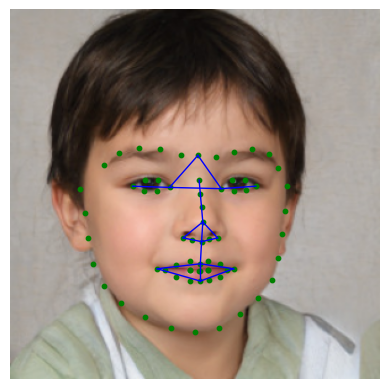

Prediction: Healthy
Confidence - Healthy: 0.85, Down Syndrome: 0.15
Inference Time: 0.0377 seconds


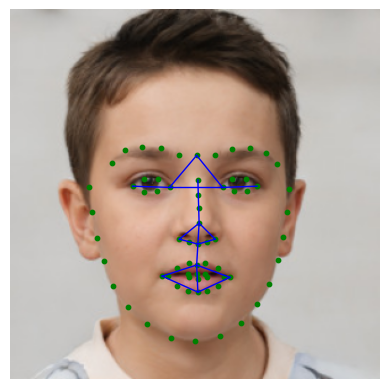

Prediction: Down Syndrome
Confidence - Healthy: 0.02, Down Syndrome: 0.98
Inference Time: 0.0269 seconds


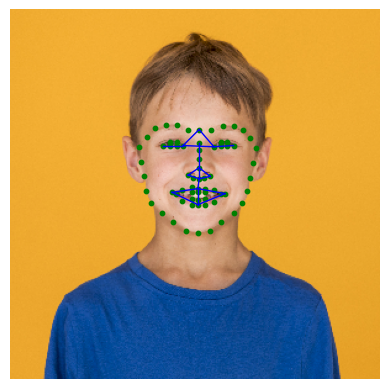

In [5]:
import cv2
import numpy as np
import joblib
import dlib
from skimage.feature import local_binary_pattern
from matplotlib import pyplot as plt
import time  # Import the time module

# Load the trained model and scaler
model_data = joblib.load('trained_model.pkl')
model = model_data['model']
scaler = model_data['scaler']

# Load Dlib facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

# Constants for LBP
RADIUS = 2
POINTS = 8 * RADIUS
METHOD = 'uniform'
PATCH_SIZE = 16

# List of specific landmarks to extract patches from
landmark_indices = [
    36, 39, 42, 45, 27, 30, 33, 31, 35, 51, 48, 54, 57, 68
]

# Define landmark pairs for geometric features
pairs = [
    (36, 39), (39, 42), (42, 45), (27, 30), (30, 33),
    (33, 31), (33, 35), (30, 31), (30, 35), (33, 51),
    (51, 48), (51, 54), (51, 57), (48, 57), (54, 57),
    (39, 68), (42, 68)
]

# Check if the face is frontal by verifying symmetry
def is_frontal_face(landmarks):
    left_eye = np.mean(np.array(landmarks[36:42]), axis=0)
    right_eye = np.mean(np.array(landmarks[42:48]), axis=0)
    nose_tip = np.array(landmarks[30])
    eye_distance = np.linalg.norm(left_eye - right_eye)
    nose_to_left_eye = np.linalg.norm(nose_tip - left_eye)
    nose_to_right_eye = np.linalg.norm(nose_tip - right_eye)
    symmetry_threshold = 0.15 * eye_distance
    return abs(nose_to_left_eye - nose_to_right_eye) < symmetry_threshold

# Function to get landmarks and add the 69th point
def get_landmarks(image_input):
    if isinstance(image_input, str):
        img = cv2.imread(image_input)
    else:
        img = image_input
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face)
        points = [(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)]
        midpoint_x = (points[21][0] + points[22][0]) // 2
        midpoint_y = (points[21][1] + points[22][1]) // 2
        points.append((midpoint_x, midpoint_y))
        if is_frontal_face(points):
            return points
    return None

# Improved data augmentation function
def augment_image(image):
    augmented_images = []
    # Flip horizontally
    augmented_images.append(cv2.flip(image, 1))
    # Rotation
    rows, cols = image.shape[:2]
    for angle in [-15, -10, 0, 10, 15]:
        M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
        augmented_images.append(cv2.warpAffine(image, M, (cols, rows)))
    # Add Gaussian noise
    noise = np.random.normal(0, 10, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    augmented_images.append(noisy_image)
    return augmented_images

# Function to extract patches around specific landmarks
def extract_patches(image, landmarks, indices, patch_size=PATCH_SIZE):
    patches = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    for idx in indices:
        (x, y) = landmarks[idx]
        x_start = max(x - patch_size // 2, 0)
        y_start = max(y - patch_size // 2, 0)
        x_end = min(x + patch_size // 2, gray.shape[1])
        y_end = min(y + patch_size // 2, gray.shape[0])
        patch = gray[y_start:y_end, x_start:x_end]
        if patch.size > 0:
            patches.append(patch)
    return patches

# Function to extract LBP features from patches
def extract_lbp_from_patches(patches, radius=RADIUS, points=POINTS, method=METHOD):
    lbp_features = []
    for patch in patches:
        lbp = local_binary_pattern(patch, points, radius, method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, points + 3), range=(0, points + 2))
        hist = hist.astype("float")
        hist /= (hist.sum() + 1e-6)
        lbp_features.extend(hist)
    return lbp_features

# Function to extract geometric features from specific landmark pairs
def extract_geometric_features(landmarks, pairs):
    geom_features = []
    for i, j in pairs:
        p1 = landmarks[i]
        p2 = landmarks[j]
        distance = np.linalg.norm(np.array(p1) - np.array(p2))
        geom_features.append(distance)
    return geom_features

# Function to extract combined features (LBP + Geometric)
def get_combined_features(image, pairs):
    landmarks = get_landmarks(image)
    if landmarks:
        patches = extract_patches(image, landmarks, landmark_indices)
        lbp_features = extract_lbp_from_patches(patches)
        geom_features = extract_geometric_features(landmarks, pairs)
        combined_features = lbp_features + geom_features
        return combined_features
    return None

# Function to plot landmarks on images
def plot_landmarks(image, landmarks):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    for x, y in landmarks:
        plt.scatter(x, y, color='green', s=10)  # Green dots for landmarks
    for (i, j) in pairs:
        x1, y1 = landmarks[i]
        x2, y2 = landmarks[j]
        plt.plot([x1, x2], [y1, y2], color='blue', linewidth=1)  # Blue lines connecting pairs
    plt.axis('off')
    plt.show()

# Function to analyze an image
def analyze_image(image_path):
    img = cv2.imread(image_path)
    if img is not None:
        img = cv2.resize(img, (300, 300))

        # Start timing
        start_time = time.time()

        # Run the model prediction
        features = get_combined_features(img, pairs)
        if features:
            features = np.nan_to_num(features)
            features = scaler.transform([features])
            probabilities = model.predict_proba(features)[0]
            prediction = model.predict(features)[0]

            # End timing
            end_time = time.time()
            inference_time = end_time - start_time

            # Print the prediction results
            label = "Down Syndrome" if prediction == 1 else "Healthy"
            print(f"Prediction: {label}")
            print(f"Confidence - Healthy: {probabilities[0]:.2f}, Down Syndrome: {probabilities[1]:.2f}")
            print(f"Inference Time: {inference_time:.4f} seconds")

            # Extract landmarks
            landmarks = get_landmarks(img)

            # Plot landmarks if found
            if landmarks:
                plot_landmarks(img, landmarks)
            else:
                print("No frontal face detected in the image.")
        else:
            print("No features could be extracted from the image.")
    else:
        print("Image not found or could not be loaded.")

# Example usage
analyze_image('test/1.jpg')
analyze_image('test/2.jpg')
analyze_image('test/3.jpg')
